In [29]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [2]:
data = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

/anaconda2/envs/py36-test/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = data
df['game_date'] = pd.to_datetime(df['game_date'])
plays_keep = ["run","pass"]
df = df[df["play_type"].isin(plays_keep)] 
df = df[df["qb_kneel"]==0]
df = df[df["qb_spike"]==0]
df["play"] = pd.get_dummies(df.play_type)["pass"].values
df.head(10)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,play
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0
6,183,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
7,207,2009091000,PIT,TEN,TEN,away,PIT,TEN,94.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0
9,253,2009091000,PIT,TEN,PIT,home,TEN,TEN,43.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
10,277,2009091000,PIT,TEN,PIT,home,TEN,TEN,40.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1
11,301,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0
12,322,2009091000,PIT,TEN,PIT,home,TEN,TEN,31.0,2009-09-10,...,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1


In [4]:
feats = list(df.columns)
feats

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [5]:
def analysis(data):
    fig1, axs1 = plt.subplots(1,3,figsize=(15,3.5))
    print ("PlayTypes:", set(data.play_type))
    data.play_type.value_counts().plot('bar',title="PlayType Histogram",ax=axs1[0])
    sg = data.play_type.where(data.shotgun == 1)
    n_sg = data.play_type.where(data.shotgun == 0)
    sg.value_counts().plot('bar',title="PlayType Histogram (Shotgun)",ax=axs1[1])
    n_sg.value_counts().plot('bar',title="PlayType Histogram (QB Under Center)",ax=axs1[2])
    
    fig2, axs2 = plt.subplots(1,1,figsize=(10,5))
    types = ["pass","run","field_goal","other"]
    td_pr_pass = data.td_prob.where(data.play_type == "pass")
    td_pr_run = data.td_prob.where(data.play_type == "run")
    td_pr_fg = data.td_prob.where(data.play_type == "field_goal")
    td_pr_other = data.td_prob.where((data.play_type != "pass") & (data.play_type != "run") & (data.play_type != "field_goal"))
    axs2.hist([td_pr_pass,td_pr_run,td_pr_fg,td_pr_other],density=True,histtype='bar',label=types)
    axs2.set_title("Touchdown Prob")
    axs2.set_xlabel("Probability")
    axs2.legend()
    

PlayTypes: {'pass', 'run'}


/anaconda2/envs/py36-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6735: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/anaconda2/envs/py36-test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6736: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/anaconda2/envs/py36-test/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


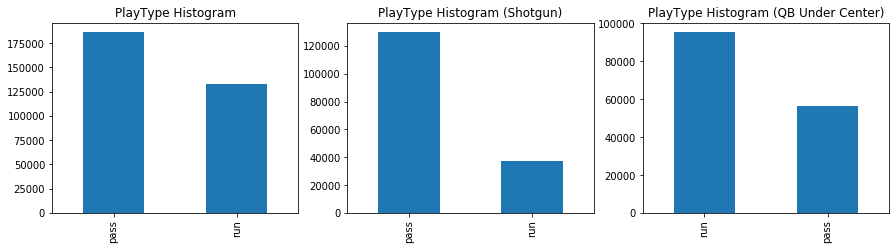

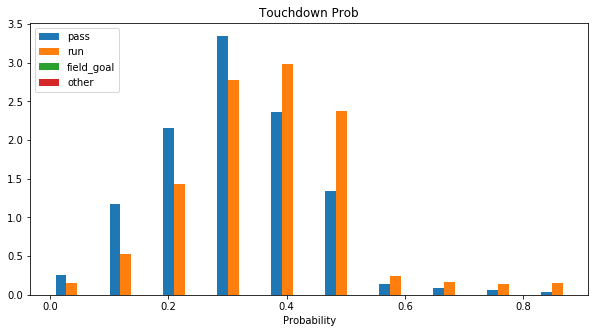

In [6]:
analysis(df)

In [7]:
np.sort(df.air_yards)[:25]

array([-70., -66., -52., -50., -48., -48., -47., -46., -43., -41., -38.,
       -38., -38., -38., -37., -36., -32., -31., -30., -30., -29., -29.,
       -29., -27., -25.])

In [8]:
df.describe()

,play_id,game_id,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,...,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,play
count,319369.000000,3.193690e+05,319369.000000,319369.000000,319352.000000,319355.000000,319369.0,319369.000000,319369.000000,319369.000000,...,4983.000000,39.000000,319365.000000,4169.000000,319369.000000,319369.000000,319369.000000,319369.0,319369.0,319369.000000
mean,2092.072001,2.013608e+09,52.417154,436.566633,850.297318,1741.289001,0.0,12.050785,0.040474,2.557512,...,2.659843,5.794872,0.190400,11.599664,0.002433,0.000044,0.000006,0.0,0.0,0.584518
std,1228.924414,2.838385e+06,24.667096,269.941545,540.417535,1046.525797,0.0,7.071871,0.197067,1.131707,...,9.790914,16.282343,2.677649,4.151314,0.049265,0.006621,0.002502,0.0,0.0,0.492806
min,48.000000,2.009091e+09,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.000000,...,-34.000000,-16.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,1022.000000,2.011111e+09,34.000000,192.000000,360.000000,828.500000,0.0,6.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
50%,2098.000000,2.013123e+09,56.000000,428.000000,843.000000,1795.000000,0.0,12.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
75%,3126.000000,2.016103e+09,73.000000,671.000000,1318.000000,2632.000000,0.0,18.000000,0.000000,4.000000,...,0.000000,5.500000,0.000000,15.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000
max,5637.000000,2.018122e+09,99.000000,900.000000,1800.000000,3600.000000,0.0,38.000000,1.000000,5.000000,...,93.000000,77.000000,104.000000,18.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000


In [9]:
plays = df[['yardline_100','quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining',
        'drive','qtr','down','goal_to_go','ydstogo','shotgun','no_huddle','posteam_timeouts_remaining',
        'defteam_timeouts_remaining','posteam_score','defteam_score','score_differential','play']].dropna()

X = plays[['yardline_100','quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining',
        'drive','qtr','down','goal_to_go','ydstogo','shotgun','no_huddle','posteam_timeouts_remaining',
        'defteam_timeouts_remaining','posteam_score','defteam_score','score_differential']]
Y = plays['play']

xTrain = X[df['game_date'] < pd.Timestamp(2018,6,1)]
xTest = X[df['game_date'] >= pd.Timestamp(2018,6,1)]

yTrain = Y[df['game_date'] < pd.Timestamp(2018,6,1)].values
yTest = Y[df['game_date'] >= pd.Timestamp(2018,6,1)].values

/anaconda2/envs/py36-test/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/anaconda2/envs/py36-test/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
graph = xTrain[['yardline_100','quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining',
        'down','ydstogo','shotgun','no_huddle','score_differential']]
graph.head(10)

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,ydstogo,shotgun,no_huddle,score_differential
1,58.0,893.0,1793.0,3593.0,1.0,10,0,0,0.0
2,53.0,856.0,1756.0,3556.0,2.0,5,0,0,0.0
3,56.0,815.0,1715.0,3515.0,3.0,8,1,0,0.0
5,98.0,796.0,1696.0,3496.0,1.0,10,0,0,0.0
6,98.0,760.0,1660.0,3460.0,2.0,10,0,0,0.0
7,94.0,731.0,1631.0,3431.0,3.0,6,1,0,0.0
9,43.0,684.0,1584.0,3384.0,1.0,10,0,0,0.0
10,40.0,648.0,1548.0,3348.0,2.0,7,0,0,0.0
11,30.0,621.0,1521.0,3321.0,1.0,10,0,0,0.0
12,31.0,583.0,1483.0,3283.0,2.0,11,0,0,0.0


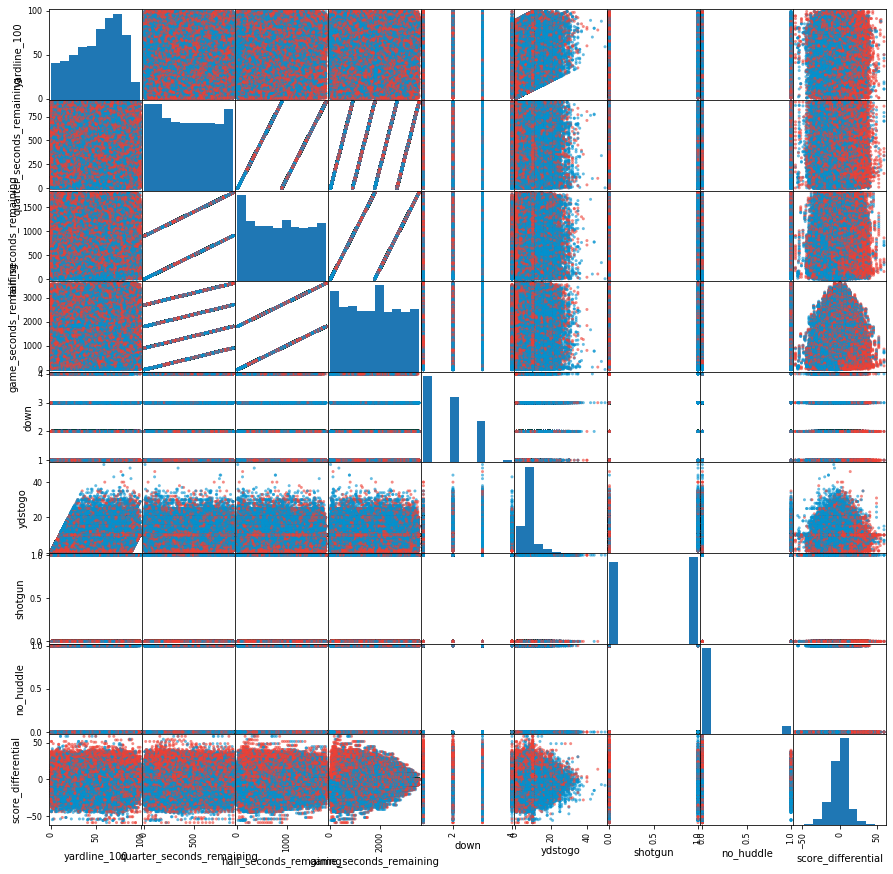

In [16]:
# https://stackoverflow.com/questions/21131707/multiple-data-in-scatter-matrix/27583955 #
color_wheel = {1: "#0392cf", 
               0: "#ee4035"}
colors = list(map(lambda y: color_wheel.get(y), yTrain.tolist()))
ax = scatter_matrix(graph, color=colors, alpha=0.6, figsize=(15, 15), diagonal='hist')

# Random Forest Model (sklearn)

In [25]:
def error(model):
    predsTr = model.predict(xTrain)
    trainingerr=np.mean(np.sign(predsTr)!=yTrain)
#     print("Training error: %2.4f" % trainingerr)

    predsTe = model.predict(xTest)
    testingerr=np.mean(np.sign(predsTe)!=yTest)
#     print("Testing error: %2.4f" % testingerr)
    
    return trainingerr, testingerr

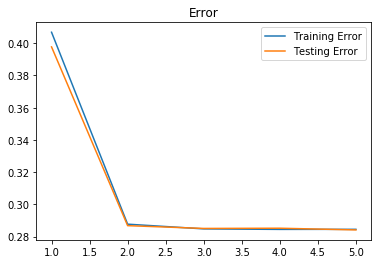

In [27]:
depth = range(1,6)
errorTr = []
errorTe = []
for d in depth:
    clf = RandomForestClassifier(n_estimators=100,max_depth=d,random_state=0)
    clf.fit(xTrain, yTrain)

    trainingerr, testingerr = error(clf)
    errorTr.append(trainingerr)
    errorTe.append(testingerr)

plt.plot(depth, errorTr)
plt.plot(depth, errorTe)
plt.title("Error")
plt.legend(['Training Error', 'Testing Error'], loc='upper right')
plt.show()

# Random Forest Model (XGBoost)

In [30]:
data_dmatrix = xgb.DMatrix(data=xTrain,label=yTrain)

In [36]:
xg_reg = xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.3,learning_rate=0.1,max_depth=20,alpha=10,n_estimators = 100)
xg_reg.fit(xTrain,yTrain)

[12:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [37]:
predsTr = xg_reg.predict(xTrain)
trainingerr=np.mean(np.sign(predsTr)!=yTrain)
print("Training error: %2.4f" % trainingerr)

predsTe = xg_reg.predict(xTest)
testingerr=np.mean(np.sign(predsTe)!=yTest)
print("Testing error: %2.4f" % testingerr)

Training error: 0.4168
Testing error: 0.4066
